In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

In [2]:
data = pd.read_csv('samsung.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-24,25900.0,26000.0,25700.0,25700.0,259.378235,7807550.0
1,2015-12-28,25700.0,25780.0,25320.0,25320.0,255.543076,11361500.0
2,2015-12-29,25300.0,25320.0,24820.0,25080.0,1204.702881,11647200.0
3,2015-12-30,25200.0,25440.0,25080.0,25200.0,1210.466919,10197900.0
4,2016-01-04,25200.0,25200.0,24100.0,24100.0,1157.629150,15346950.0


In [3]:
# 결측치 제거
dataset = data.dropna()

In [4]:
# 중앙값 계산
high_prices = dataset['High'].values
low_prices = dataset['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [5]:
mid_prices

array([25850., 25550., 25070., ..., 72650., 73150., 76400.])

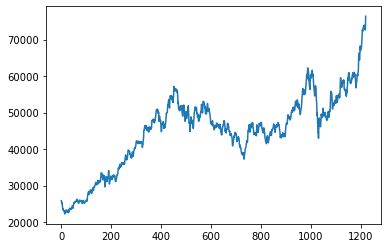

In [8]:
plt.plot(mid_prices)

In [9]:
# 50일간의 데이터로 내일 예측
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [10]:
# normalization (z-score)
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
# shuffle을 해도, 51개의 묶음은 변하지 않으므로 상관없음
# 50일(x)로 1일(y) 예측
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1053, 50, 1), (117, 50, 1))

In [11]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=10)

Epoch 1/10
106/106 [==============================] - 3s 28ms/step - loss: 0.8074 - val_loss: 0.5213
Epoch 2/10
106/106 [==============================] - 2s 22ms/step - loss: 0.3501 - val_loss: 0.2227
Epoch 3/10
106/106 [==============================] - 2s 22ms/step - loss: 0.1835 - val_loss: 0.1739
Epoch 4/10
106/106 [==============================] - 2s 23ms/step - loss: 0.1645 - val_loss: 0.1695
Epoch 5/10
106/106 [==============================] - 2s 21ms/step - loss: 0.1540 - val_loss: 0.1598
Epoch 6/10
106/106 [==============================] - 2s 21ms/step - loss: 0.1501 - val_loss: 0.1727
Epoch 7/10
106/106 [==============================] - 2s 21ms/step - loss: 0.1484 - val_loss: 0.1468
Epoch 8/10
106/106 [==============================] - 2s 21ms/step - loss: 0.1523 - val_loss: 0.1617
Epoch 9/10
106/106 [==============================] - 2s 21ms/step - loss: 0.1495 - val_loss: 0.1611
Epoch 10/10
106/106 [==============================] - 2s 21ms/step - loss: 0.1467 - val_lo

In [13]:
pred = model.predict(x_test)

In [14]:
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

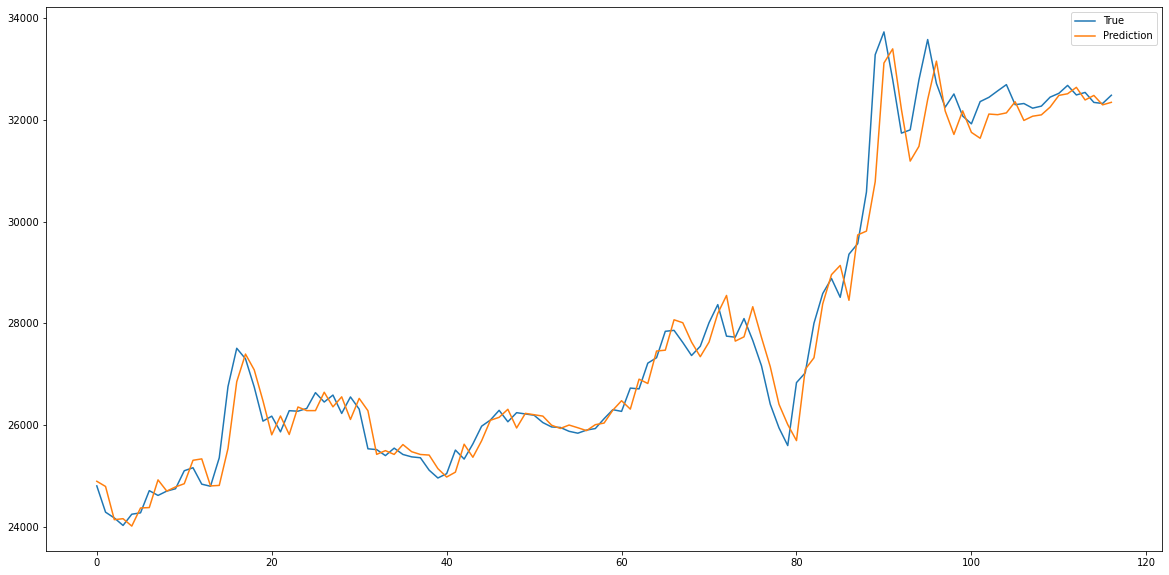

In [15]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_y, label='True')
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()

In [16]:
lt = mid_prices[-365:]
len(lt)

365

In [17]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(lt) - sequence_length):
    result.append(lt[index: index + sequence_length])

In [18]:
# z-score 정규화
normalized_data = []
window_mean = []
window_std = []

for window in result:
    normalized_window = [((p - np.mean(window)) / np.std(window)) for p in window]
    normalized_data.append(normalized_window)
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

result = np.array(normalized_data)

x_test = result[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[:, -1]

x_test.shape

(314, 50, 1)

In [19]:
pred = model.predict(x_test)

In [20]:
pred_result = []
pred_y = []
for i in range(len(pred)):
    n1 = (pred[i] * window_std[i]) + window_mean[i]
    n2 = (y_test[i] * window_std[i]) + window_mean[i]
    pred_result.append(n1)
    pred_y.append(n2)

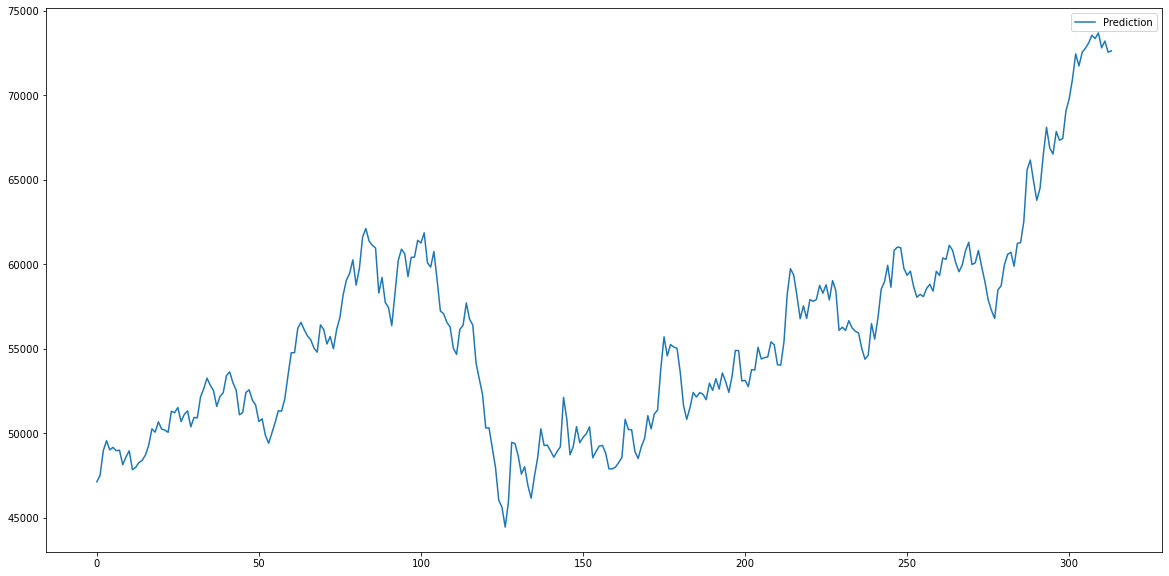

2020년 12월 25일의 주가는 73208.91
2020년 12월 26일의 주가는 72549.05
2020년 12월 27일의 주가는 72625.95


In [21]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()

print('2020년 12월 21일의 주가는', '%0.2f'%float(pred_result[-3]))
print('2020년 12월 22일의 주가는', '%0.2f'%float(pred_result[-2]))
print('2020년 12월 23일의 주가는', '%0.2f'%float(pred_result[-1]))